# I] Import functions and options

In [78]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})
from matplotlib_venn import venn2

In [79]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [80]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Data download

In [81]:
%%time
# DL data ATG7 isoform expression
path = output_file_directory + "/ATG7/dataframes_for_input/df_ATG7_NormPrim.csv"
df_ATG7_NormPrim= pandas.read_csv(path, sep = ",")

#remove Survival information
df_ATG7_NormPrim.drop(df_ATG7_NormPrim.columns[[3, 4]], axis = 1, inplace = True)

print(df_ATG7_NormPrim.shape)
df_ATG7_NormPrim.head(2)

(16614, 20)
Wall time: 96.7 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-ZTTD-0326-SM-57WFW,Normal Tissue,Muscle,5.042,3.860,2.390,0.2642,32.944283,14.519306,5.240574,1.199970,5.085097,3.955992,2.641679,20.95985,69.271996,25.002916,5.725088,0.440723,0.159074
1,GTEX-PX3G-1626-SM-2S1PT,Normal Tissue,Muscle,4.252,2.322,1.956,1.1320,19.052710,4.999249,3.878848,2.190624,4.325725,2.584782,2.286540,11.06872,45.165557,35.043325,19.791118,0.262390,0.203585


In [82]:
#split to have Normal (GTEX) and Primary (TCGA)
df_ATG7_Normal = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('GTEX')]
print(len(df_ATG7_Normal))
df_ATG7_Primary = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('TCGA')]
print(len(df_ATG7_Primary))

7429
9185


# III] ATG7 expression

## A) ATG7 expression

In [83]:
# df with only Normal 
df_sampletype= df_ATG7_Normal[['Primary_Site',
                               'ATG7_total',             
                               'ATG7_1perc',
                               'ATG7_2perc',
                               'ATG7_3perc']]

df_sampletype = df_sampletype.assign(ATG7_3perc =  df_sampletype['ATG7_3perc'].abs(),
                                     ATG7_2perc = df_sampletype['ATG7_2perc'].abs())

#Column rename
df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                        'ATG7_total': 'tpm ATG7',
                                        'ATG7_1perc' : "% ATG7(1)",
                                        'ATG7_2perc' : "% ATG7(2)",
                                        'ATG7_3perc' : "% ATG7(3)"})

#Groupby to have merge of all the primary site 
df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)

#To not have 1E-06 I change it to zero
df_sampletype['% ATG7(3)']['Fallopian Tube'] = 0

df_sampletype.head()

,tpm ATG7,% ATG7(1),% ATG7(2),% ATG7(3)
Primary Site,,,,
Adipose Tissue,13.205544,79.108597,17.604017,3.287388
Adrenal Gland,11.595699,78.829882,17.665602,3.504518
Bladder,12.009622,75.108936,21.997823,2.893243
Blood,13.524349,39.136950,47.826391,13.036660
Blood Vessel,14.225647,85.502455,12.118648,2.378900


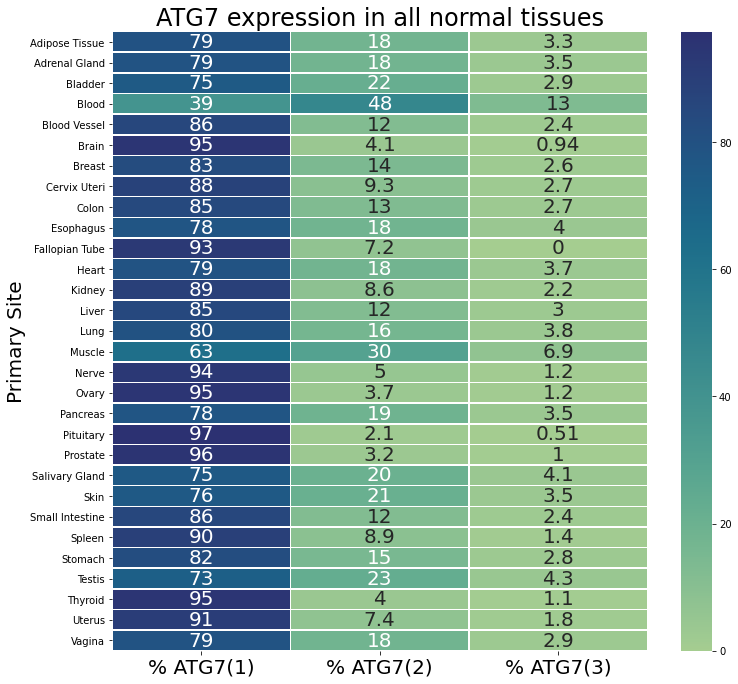

In [84]:
HeatMap_df_sampletype = df_sampletype[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
heatmap = seaborn.heatmap(HeatMap_df_sampletype, annot=True, cmap="crest", linewidths=.5)
plt.title('ATG7 expression in all normal tissues')
plt.subplots_adjust(top=1.2)

path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'heatmap_organs.svg')

In [85]:
# df with only Normal 
hist_df_sampletype = df_sampletype.reset_index()
hist_df_sampletype = hist_df_sampletype[['Primary Site','tpm ATG7']]
hist_df_sampletype.head(1)

,Primary Site,tpm ATG7
0,Adipose Tissue,13.205544


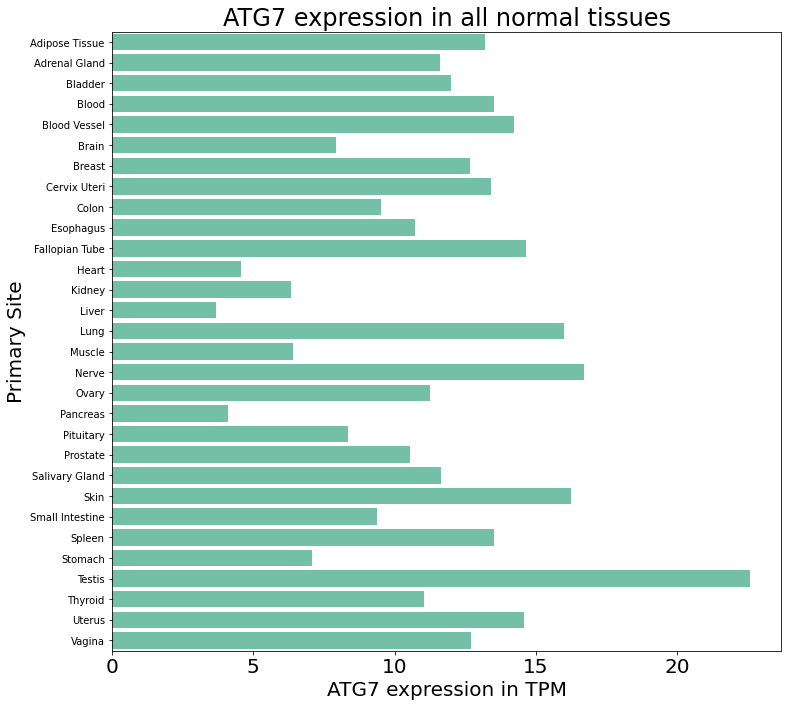

In [86]:
# Seaborn
seaborn.barplot(data = hist_df_sampletype, x =  'tpm ATG7', y = 'Primary Site', color = 'mediumaquamarine')
plt.title('ATG7 expression in all normal tissues')
plt.xlabel('ATG7 expression in TPM')
plt.subplots_adjust(top=1.2)

path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'barplot_tpm.svg')

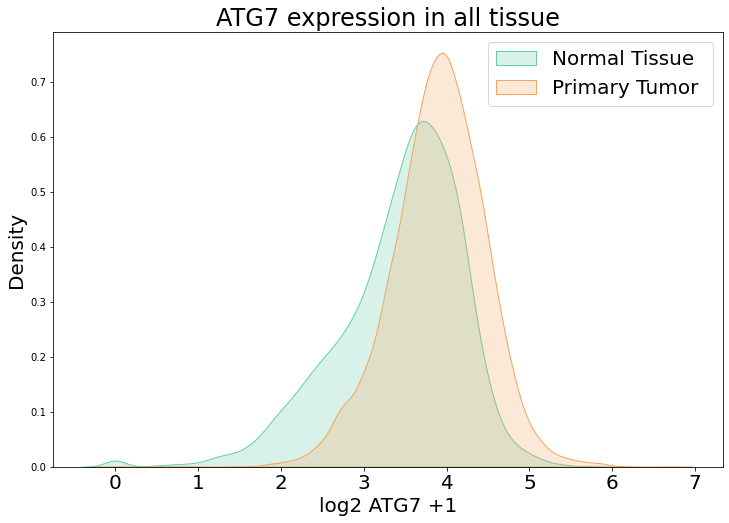

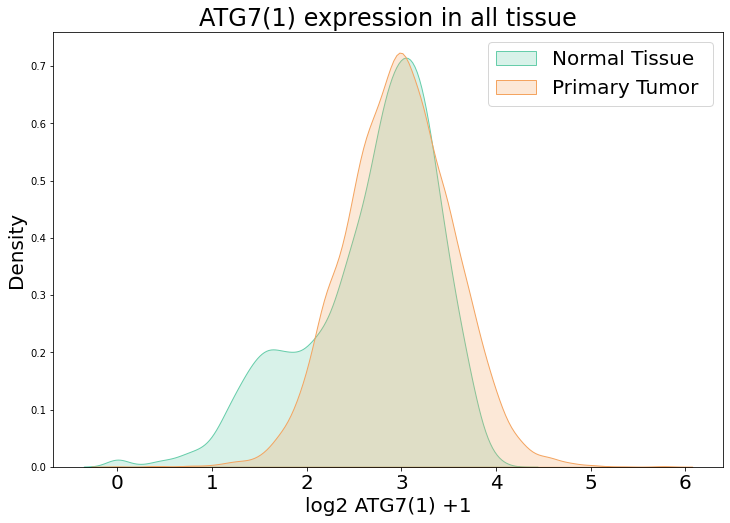

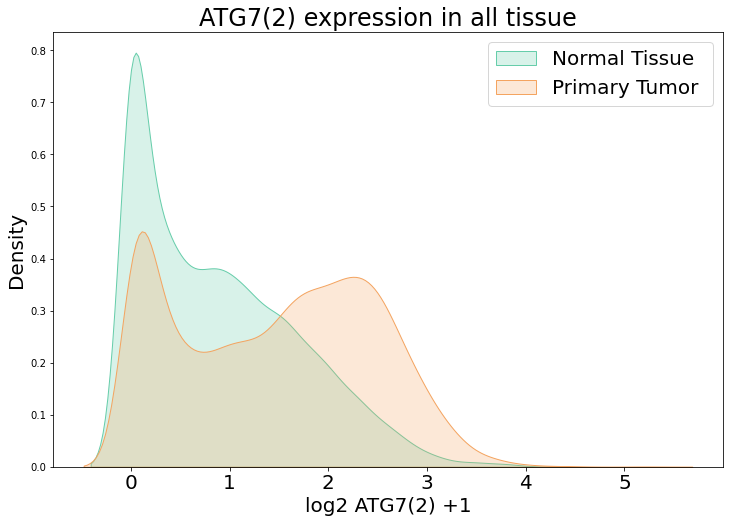

<Figure size 864x576 with 0 Axes>

In [87]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal, 'in all tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = [['log2_p1_ATG7_total', 'ATG7'], ['log2_p1_ATG7_1', 'ATG7(1)'], ['log2_p1_ATG7_2', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal Tissue","Primary Tumor "])
    title_file = 'distrib_' + isoform[1]
    path = 'ATG7/figs_ATG7_characterisation/'
    plt.savefig(output_file_directory+path+title_file+'.svg')
    plt.show()
    plt.clf()

## B) Percentage do not express ATG7 isoforms

In [88]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'all normal tissue'], [df_ATG7_Primary, 'all primary tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

for df in all_dfs:
  print(df[1])
  for isoform in isoforms:
        
    what = isoform[1]
    all_ = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all_
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', what)
  print()


all normal tissue
0.4 % of tumor do not express ATG7
0.4 % of tumor do not express ATG7(1)
24.3 % of tumor do not express ATG7(2)
59.2 % of tumor do not express ATG7(3)

all primary tumor
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
13.4 % of tumor do not express ATG7(2)
33.6 % of tumor do not express ATG7(3)



In [101]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'Normal Tissue'], [df_ATG7_Primary, 'Primary Tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

df_number_exp = []
what = []
sample_type = []
who_exp = []
perc_exp = []
    
for df in all_dfs:
    print(df[1])

    for isoform in isoforms:
        #save what isoform
        what.append(isoform[1])
        #save sample_type
        sample_type.append(df[1])
        #have total sample number
        all_ = (df[0][isoform[0]]).shape
        #calculate number of sample who express the isoform
        with_exp = (df[0][isoform[0]]>0.1).sum()
        who_exp.append(with_exp)
        #convert result to percentage
        perc_with_exp = float((with_exp*100)/all_)   
        perc_exp.append(round(perc_with_exp,1))

        #create a dictionnary and convert to dataframe
        d = dict(Isoform = what, who_express = who_exp, 
                 Percentage = perc_exp, Sample_Type = sample_type)
        df_expr_distrib = pandas.DataFrame.from_dict(d, orient='index')
        df_expr_distrib = df_expr_distrib.T
        
#save it    
df_expr_distrib

Normal Tissue
Primary Tumor


,Isoform,who_express,Percentage,Sample_Type
0,ATG7,7402,99.6,Normal Tissue
1,ATG7(1),7402,99.6,Normal Tissue
2,ATG7(2),5624,75.7,Normal Tissue
3,ATG7(3),3034,40.8,Normal Tissue
4,ATG7,9184,100,Primary Tumor
5,ATG7(1),9184,100,Primary Tumor
6,ATG7(2),7954,86.6,Primary Tumor
7,ATG7(3),6101,66.4,Primary Tumor


<AxesSubplot:xlabel='Isoform', ylabel='Percentage'>

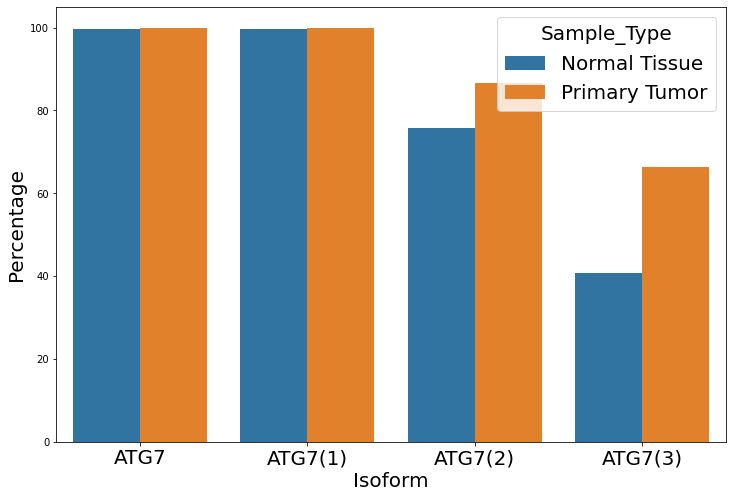

In [102]:
seaborn.barplot(x="Isoform", y="Percentage", hue="Sample_Type", data=df_expr_distrib)

## C) Expression figures

### 1) Value TPM

16614


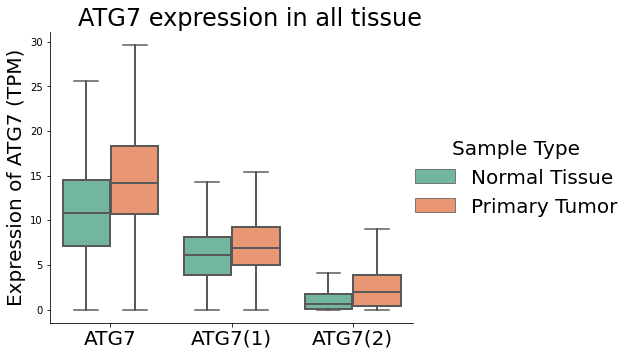

In [12]:
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(7,10)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7'
data_distrib.loc[shape: shape*2,'x'] = 'ATG7(1)'
data_distrib.loc[shape*2:,'x'] = 'ATG7(2)'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('Expression of ATG7 (TPM)')
plt.xlabel('')
plt.title('ATG7 expression in '+ info, x=.55)

#save
path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'ATG7_exp_alltissue.svg')

In [13]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_total', 'ATG7_1tpm', 'ATG7_2tpm']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all normal tissue(10.837) and all primary tumors(14.122) for ATG7_total is 0.000E+00
the pvalue between all normal tissue(6.129) and all primary tumors(6.858) for ATG7_1tpm is 6.188E-109
the pvalue between all normal tissue(0.670) and all primary tumors(1.930) for ATG7_2tpm is 0.000E+00



In [14]:
#median brut file to compare 
print(df_ATG7_NormPrim['ATG7_total'].mean())
print(df_ATG7_NormPrim['ATG7_1tpm'].mean())
print(df_ATG7_NormPrim['ATG7_2tpm'].mean())

13.330134367799564
6.849488322969236
1.8954335752090787


In [15]:
#median after modification to be sure I selected the good ones
data_distribtest = data_distrib[data_distrib['x'] == 'ATG7']
data_distribtest1 = data_distrib[data_distrib['x'] == 'ATG7(1)']
data_distribtest2 = data_distrib[data_distrib['x'] == 'ATG7(2)']
print(data_distribtest.mean())
print(data_distribtest1.mean())
print(data_distribtest2.mean())

y    13.330134
dtype: float64
y    6.849488
dtype: float64
y    1.895434
dtype: float64


### 2) Normalized

16614


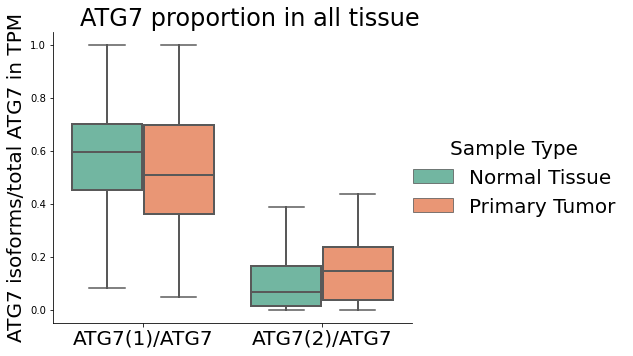

In [16]:
# NORMALiZED Distribution: Data preparation + graph
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(18,20)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7(1)/ATG7'
data_distrib.loc[shape:,'x'] = 'ATG7(2)/ATG7'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('ATG7 isoforms/total ATG7 in TPM')
plt.xlabel('')
plt.title('ATG7 proportion in '+ info, x=0.55)

#save graph
path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'prop_alltissue.svg')



In [17]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_1norm', 'ATG7_2norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between all normal tissue(0.595) and all primary tumors(0.507) for ATG7_1norm is 2.372E-53
the pvalue between all normal tissue(0.068) and all primary tumors(0.146) for ATG7_2norm is 8.074E-187



## D) Correlation between the two isoforms

The correlation between iso1 and iso2 in normal tissue is: 0.02366015296692227 0.0414250994345116


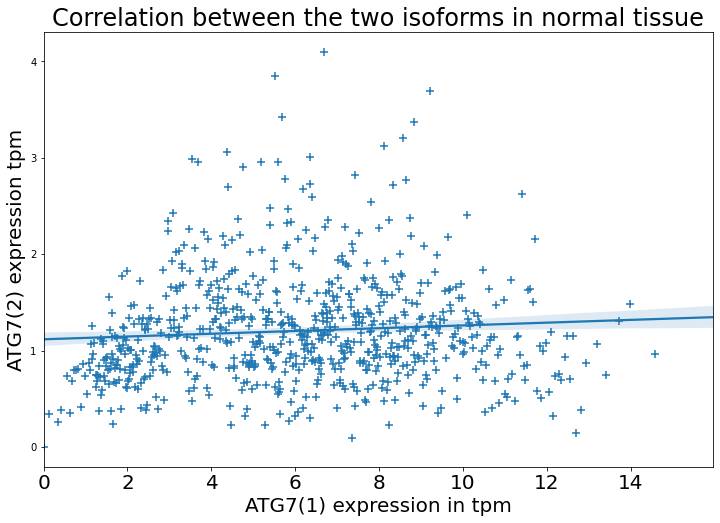


The correlation between iso1 and iso2 in primary tumor is: -0.18866448940373062 2.356258298779815e-74


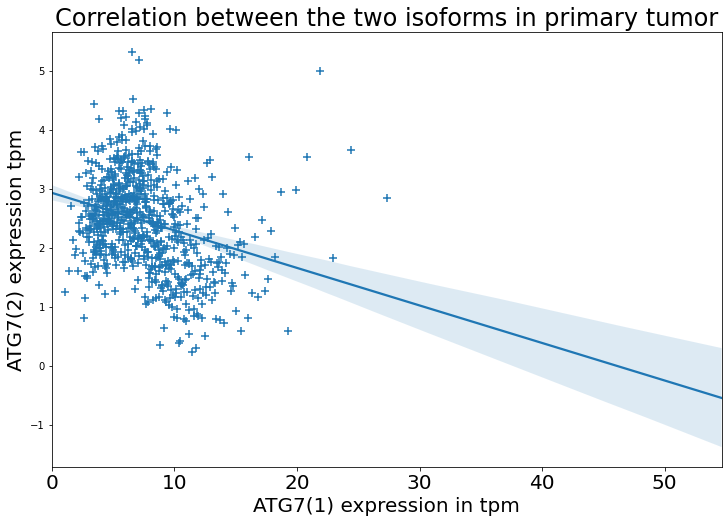

<Figure size 864x576 with 0 Axes>

In [18]:
#isoform correlation in all tissue 
#remove the extrems
tissues = [[df_ATG7_Normal, "normal tissue"], [df_ATG7_Primary, "primary tumor"]]

for tissue in tissues: 
  x = tissue[0]['ATG7_1tpm'].to_list()
  y = tissue[0]['ATG7_2tpm'].to_list()

  r_value, p_value = scipy.stats.spearmanr(x, y)
  print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)

  seaborn.regplot(x=x,y=y, x_bins=800, x_ci = 0, marker="+")
  name = "Correlation between the two isoforms in "+  tissue[1]
  plt.title(name)
  plt.xlabel("ATG7(1) expression in tpm")
  plt.ylabel('ATG7(2) expression tpm')
  title_file = 'ATG7s_corr_' + tissue[1]
  
  #save
  path = 'ATG7/figs_ATG7_characterisation/'
  plt.savefig(output_file_directory+path+'prop_alltissue.svg')
  
  plt.show()  
  plt.clf()
  print()